In [2]:
] activate .

In [ ]:
# ] instantiate

In [3]:
using Revise, StableDQMC, GenericSVD, JacobiSVD, LinearAlgebra, Plots, Statistics, LaTeXStrings, DataStructures
using BenchmarkTools, StatsPlots, DataFrames

pyplot();
PyPlot.plt.style.use("publication_tex")
default(
    framestyle = :grid,
    grid = true,
    guidefont=font(15),
#     framestyle = :box,
#     grid = false,
#     guidefont=font(18),
    legend = true,
    size = (1.6*360, 360),
    xtickfont=font(13), 
    ytickfont=font(13), 
    legendfont=font(12),
    linewidth = 1.5
);

# default(
#     framestyle = :box,
#     legend = true,
#     grid = false,
#     size = (1.5*250, 250),
#     xtickfont=font(8), 
#     ytickfont=font(8), 
#     guidefont=font(11),
#     legendfont=font(8),
#     linewidth = 1
# );

In [4]:
# Some basic tests
B = rand(5,5) # regular matrix
N = 10
@assert isapprox(calc_Bchain(B, N)[1], B^N)
@assert isapprox(Matrix(calc_Bchain_svd(B, N; svdalg = gesdd)[1]), B^N)
@assert isapprox(Matrix(calc_Bchain_svd(B, N; svdalg =  gesvd)[1]), B^N)
@assert isapprox(Matrix(calc_Bchain_svd(B, N; svdalg =  genericsvd)[1]), B^N)
@assert isapprox(Matrix(calc_Bchain_qr(B, N)[1]), B^N)
# @assert isapprox(calc_Bchain_stabilized(B, N, gesvj)[1], B^N)

# Non-interacting system

In [141]:
n = 8
t = -1
μ = -0.1
Δτ = 0.1
T = diagm(-1 => fill(-t, n-1), 1 => fill(-t, n-1), 0 => fill(μ, n))

# PBC
T[1,end] = -t
T[end,1] = -t

# B from spin-fermion model
#B = [0.975173 0.0971936 0.192475 0.0191836 0.0 0.0 0.0 0.0; 0.0971936 0.975173 0.0191836 0.192475 0.0 0.0 0.0 0.0; 0.192475 0.0191836 0.975173 0.0971936 0.0 0.0 0.0 0.0; 0.0191836 0.192475 0.0971936 0.975173 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.975173 -0.192475 -0.0971936 0.0191836; 0.0 0.0 0.0 0.0 -0.192475 0.975173 0.0191836 -0.0971936; 0.0 0.0 0.0 0.0 -0.0971936 0.0191836 0.975173 -0.192475; 0.0 0.0 0.0 0.0 0.0191836 -0.0971936 -0.192475 0.975173]

B = exp(-Δτ .* T)

8×8 Array{Float64,2}:
  1.02018      -0.101511      0.00506711   …   0.00506711   -0.101511   
 -0.101511      1.02018      -0.101511        -0.000168847   0.00506711 
  0.00506711   -0.101511      1.02018          8.43393e-6   -0.000168847
 -0.000168847   0.00506711   -0.101511        -0.000168847   8.43393e-6 
  8.43393e-6   -0.000168847   0.00506711       0.00506711   -0.000168847
 -0.000168847   8.43393e-6   -0.000168847  …  -0.101511      0.00506711 
  0.00506711   -0.000168847   8.43393e-6       1.02018      -0.101511   
 -0.101511      0.00506711   -0.000168847     -0.101511      1.02018    

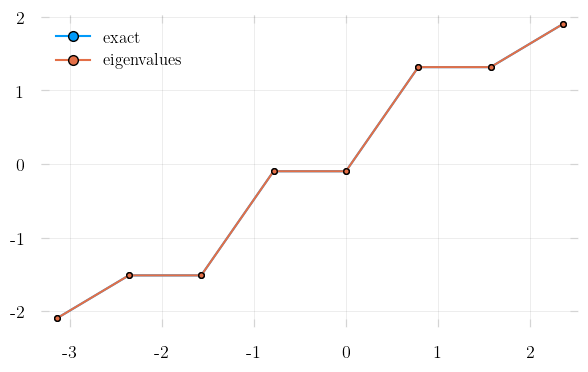

In [13]:
# Compare to exact discretized energies
ks = LinRange(-pi, pi, n+1)[1:end-1]
ϵ(k) = -2*t*cos(k) + μ
sort(ϵ.(ks))

plot(ks, sort(ϵ.(ks)), marker=true, label="exact")
plot!(ks, eigvals(T), marker=true, label="eigenvalues")

In [7]:
cond(B)

1.4918246976412697

In [8]:
kappa(N) = exp(4abs(t)*N*Δτ)

kappa (generic function with 1 method)

In [9]:
cond(B)

1.4918246976412697

In [10]:
kappa(1)

1.4918246976412703

In [11]:
estimate_breakdown(sigdigits) = sigdigits * log(10) / (4 * abs(t) * Δτ)

estimate_breakdown (generic function with 1 method)

In [12]:
estimate_breakdown(17)

97.85986645224693

In [14]:
Bbig = BigFloat.(B)
N = 500

setprecision(100) do
    global svs_genericsvd = calc_Bchain_svd(Bbig, N; svdalg = genericsvd)[2];
end
svs_qr_udt = calc_Bchain_qr(B, N)[2];
svs_gesvd  = calc_Bchain_svd(B, N; svdalg = gesvd)[2];
svs_gesdd  = calc_Bchain_svd(B, N; svdalg = gesdd)[2];
svs_gesvj  = calc_Bchain_svd(B, N; svdalg = gesvj)[2];

In [15]:
cond(exp.(svs_qr_udt[end,:]))

9.032467210156366e85

In [16]:
kappa(N)

7.225973768125749e86

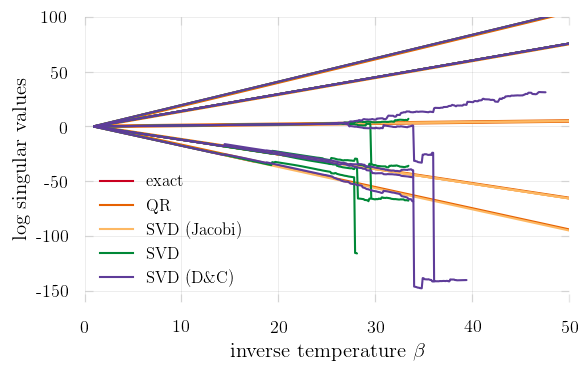

In [17]:
betas = range(1, N * 0.1, length=N)
plot(betas, svs_genericsvd, color="#CA0020", labels = reshape(["exact", "", "","", "","", "", ""], (1,8)))
plot!(betas, svs_qr_udt, color="#E66101", labels = reshape(["QR", "", "","", "","", "", ""], (1,8)))
plot!(betas, svs_gesvj, color="#FDB863", labels = reshape(["SVD (Jacobi)", "", "","", "","", "", ""], (1,8)))
plot!(betas, svs_gesvd, color="#008837", labels = reshape(["SVD", "", "","", "","", "", ""], (1,8)))
plot!(betas, svs_gesdd, color="#5E3C99", labels = reshape(["SVD (D\\&C)", "", "","", "","", "", ""], (1,8)))

ylabel!("log singular values")
xlabel!(L"inverse temperature $\beta$")
ylims!(-160, 100)
xlims!(0., 50.)
savefig("../paper/figures/decomp_comparison_simple.pdf")

## Stabilization - principle issue

In [19]:
svs_naive = calc_Bchain(B, N)[2];

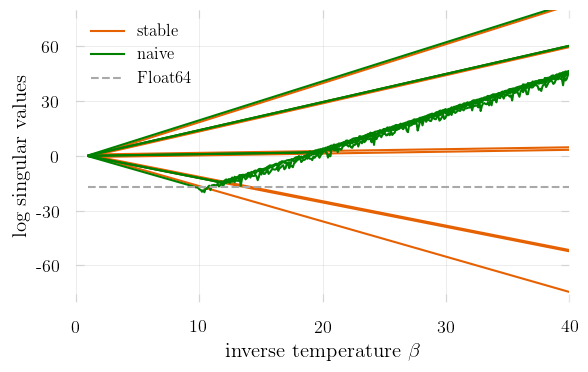

In [20]:
betas = range(1, N * 0.1, length=N)
# plot(svs_genericsvd, color="#CA0020", labels = reshape(["exact", "", "","", "","", "", ""], (1,8)))
plot(betas, svs_qr_udt, color="#E66101", labels = reshape(["stable", "", "","", "","", "", ""], (1,8)))
plot!(betas, svs_naive, color=:green, labels = reshape(["naive", "", "","", "","", "", ""], (1,8)))
plot!(1:40, fill(-17, 40), color=:darkgray, linestyle=:dash, label = "Float64")

ylabel!("log singular values")
xlabel!(L"inverse temperature $\beta$")
ylims!(-80, 80)
xlims!((0., 40.))
savefig("../paper/figures/naive_vs_stable.pdf")

In [21]:
using DoubleFloats
Bdb64 = Double64.(B)
svs_naive = calc_Bchain(Bdb64, N)[2];

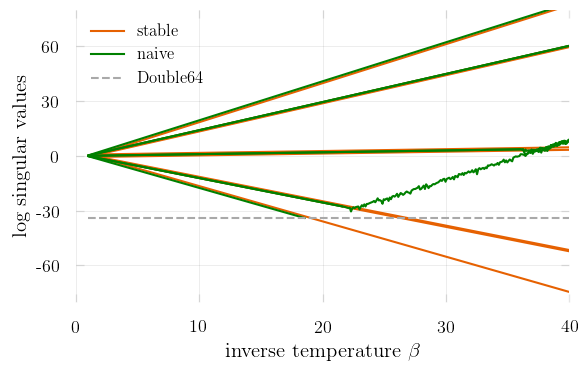

In [22]:
betas = range(1, N * 0.1, length=N)
# plot(svs_genericsvd, color="#CA0020", labels = reshape(["exact", "", "","", "","", "", ""], (1,8)))
plot(betas, svs_qr_udt, color="#E66101", labels = reshape(["stable", "", "","", "","", "", ""], (1,8)))
plot!(betas, svs_naive, color=:green, labels = reshape(["naive", "", "","", "","", "", ""], (1,8)))
plot!(1:40, fill(-34, 40), color=:darkgray, linestyle=:dash, label = "Double64")

ylabel!("log singular values")
xlabel!(L"inverse temperature $\beta$")
ylims!(-80, 80)
xlims!((0., 40.))
savefig("../paper/figures/naive_vs_stable_db64.pdf")

# Accuracy: Greens

In [39]:
function accuracy_greens(B; svdinversion = inv_one_plus)
    Bbig = BigFloat.(B)
    
    Δs_qr    = SortedDict{Int, Float64}()
    Δs_gesvd = SortedDict{Int, Float64}()
    Δs_gesdd = SortedDict{Int, Float64}()
    Δs_gesvj = SortedDict{Int, Float64}()
    
    for beta in range(5, 40, step=5)
        N = Int(beta * 10)
        
        local G_genericsvd
        setprecision(1000) do
            F_genericsvd = calc_Bchain_svd(Bbig, N; svdalg = genericsvd)[1];
            G_genericsvd = inv(I + Matrix(F_genericsvd))
        end
        
        # Bchain
        F_qr_udt = calc_Bchain_qr(B, N)[1];
        F_gesvd  = calc_Bchain_svd(B, N; svdalg = gesvd)[1];
        F_gesdd  = calc_Bchain_svd(B, N; svdalg = gesdd)[1];
        F_gesvj  = calc_Bchain_svd(B, N; svdalg = gesvj)[1];
        
        # inversion
        G_qr_udt = inv_one_plus(F_qr_udt)
        G_gesvd  = svdinversion(F_gesvd)
        G_gesdd  = svdinversion(F_gesdd)
        G_gesvj  = svdinversion(F_gesvj)
        
        Δs_qr[beta]    = maximum(abs.(G_qr_udt - G_genericsvd))
        Δs_gesvd[beta] = maximum(abs.(G_gesvd - G_genericsvd))
        Δs_gesdd[beta] = maximum(abs.(G_gesdd - G_genericsvd))
        Δs_gesvj[beta] = maximum(abs.(G_gesvj - G_genericsvd))
    end
    

    return Δs_qr, Δs_gesvd, Δs_gesdd, Δs_gesvj
end

accuracy_greens (generic function with 1 method)

In [40]:
Δs_qr, Δs_gesvd, Δs_gesdd, Δs_gesvj = accuracy_greens(B);

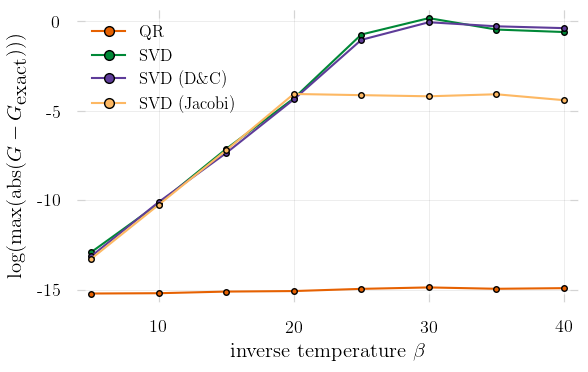

In [41]:
betas = collect(keys(Δs_qr))
p = plot(betas, log.(10, values(Δs_qr)), color="#E66101", marker=true, label="QR")
plot!(betas, log.(10, values(Δs_gesvd)), color="#008837", marker=true, label="SVD")
plot!(betas, log.(10, values(Δs_gesdd)), color="#5E3C99", marker=true, label="SVD (D\\&C)")
plot!(betas, log.(10, values(Δs_gesvj)), color="#FDB863", marker=true, label="SVD (Jacobi)")

xlabel!(L"inverse temperature $\beta$")
ylabel!(L"\log(\textrm{max}(\textrm{abs}(G - G_{\textrm{exact}})))")
# ylims!(0., 1e-3)
savefig("../paper/figures/accuracy_greens_svd_regularinv.pdf")

In [42]:
Δs_qr, Δs_gesvd, Δs_gesdd, Δs_gesvj = accuracy_greens(B, svdinversion = inv_one_plus_loh);

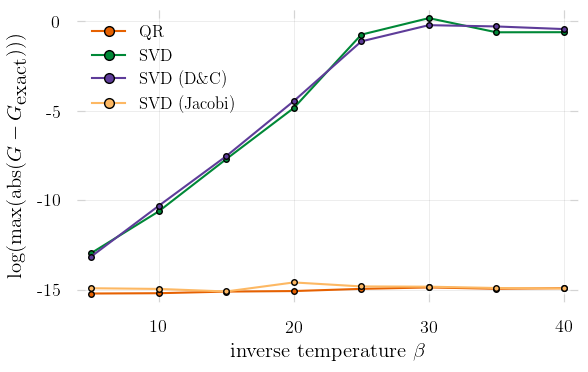

In [43]:
betas = collect(keys(Δs_qr))
p = plot(betas, log.(10, values(Δs_qr)), color="#E66101", marker=true, label="QR")
plot!(betas, log.(10, values(Δs_gesvd)), color="#008837", marker=true, label="SVD")
plot!(betas, log.(10, values(Δs_gesdd)), color="#5E3C99", marker=true, label="SVD (D\\&C)")
plot!(betas, log.(10, values(Δs_gesvj)), color="#FDB863", marker=true, label="SVD (Jacobi)")

xlabel!(L"inverse temperature $\beta$")
ylabel!(L"\log(\textrm{max}(\textrm{abs}(G - G_{\textrm{exact}})))")
savefig("../paper/figures/accuracy_greens_svd_loh.pdf")

# Accuracy: Determinant

In [54]:
absdiff(x,y) = abs(x-y)
reldiff(x, y) = abs((x - y) / (x + y))

function accuracy_determinant(B; svdinversion = svd_inv_one_plus)
    Bbig = BigFloat.(B)
    
    Δs_abs_qr    = SortedDict{Int, Float64}()
    Δs_abs_gesvd = SortedDict{Int, Float64}()
    Δs_abs_gesdd = SortedDict{Int, Float64}()
    Δs_abs_gesvj = SortedDict{Int, Float64}()
    
    Δs_rel_qr    = SortedDict{Int, Float64}()
    Δs_rel_gesvd = SortedDict{Int, Float64}()
    Δs_rel_gesdd = SortedDict{Int, Float64}()
    Δs_rel_gesvj = SortedDict{Int, Float64}()
    
    for beta in range(5, 40, step=5)
        N = Int(beta * 10)
        
        local det_genericsvd
        setprecision(1000) do
            F_genericsvd = calc_Bchain_svd(Bbig, N; svdalg = genericsvd)[1];
            det_genericsvd = prod(svd_inv_one_plus(F_genericsvd).S)
        end
        
        # Bchain
        F_qr_udt   = calc_Bchain_qr(B, N)[1];
        F_gesvd    = calc_Bchain_svd(B, N; svdalg = gesvd)[1];
        F_gesdd    = calc_Bchain_svd(B, N; svdalg = gesdd)[1];
        F_gesvj    = calc_Bchain_svd(B, N; svdalg = gesvj)[1];
        
        # inversion + det extraction
        det_qr_udt = prod(udt_inv_one_plus(F_qr_udt).D)
        det_gesvd  = prod(svdinversion(F_gesvd; svdalg = gesvd!).S)
        det_gesdd  = prod(svdinversion(F_gesdd; svdalg = gesdd!).S)
        det_gesvj  = prod(svdinversion(F_gesvj; svdalg = StableDQMC.gesvj!).S)
        
        Δs_abs_qr[beta]    = absdiff(det_qr_udt, det_genericsvd)
        Δs_abs_gesvd[beta] = absdiff(det_gesvd, det_genericsvd)
        Δs_abs_gesdd[beta] = absdiff(det_gesdd, det_genericsvd)
        Δs_abs_gesvj[beta] = absdiff(det_gesvj, det_genericsvd)
        
        Δs_rel_qr[beta]    = reldiff(det_qr_udt, det_genericsvd)
        Δs_rel_gesvd[beta] = reldiff(det_gesvd, det_genericsvd)
        Δs_rel_gesdd[beta] = reldiff(det_gesdd, det_genericsvd)
        Δs_rel_gesvj[beta] = reldiff(det_gesvj, det_genericsvd)
    end
    

    return Δs_abs_qr, Δs_abs_gesvd, Δs_abs_gesdd, Δs_abs_gesvj,
            Δs_rel_qr, Δs_rel_gesvd, Δs_rel_gesdd, Δs_rel_gesvj
end

accuracy_determinant (generic function with 1 method)

In [55]:
Δs_abs_qr, Δs_abs_gesvd, Δs_abs_gesdd, Δs_abs_gesvj,
Δs_rel_qr, Δs_rel_gesvd, Δs_rel_gesdd, Δs_rel_gesvj = accuracy_determinant(B, svdinversion = svd_inv_one_plus)

(SortedDict(5=>2.27871e-27,10=>3.48077e-38,15=>1.25375e-49,20=>4.12989e-61,25=>4.19818e-73,30=>1.13429e-84,35=>1.02002e-95,40=>4.05973e-107), SortedDict(5=>1.86139e-25,10=>5.23256e-34,15=>2.27432e-42,20=>2.08581e-51,25=>1.06769e-62,30=>1.50609e-68,35=>1.27441e-78,40=>8.08138e-90), SortedDict(5=>1.54837e-25,10=>3.54845e-34,15=>1.36759e-42,20=>8.51724e-51,25=>6.08682e-60,30=>3.17478e-71,35=>9.50838e-82,40=>2.63012e-93), SortedDict(5=>2.56805e-27,10=>3.21632e-39,15=>1.17846e-49,20=>7.53827e-61,25=>2.923e-72,30=>7.63308e-84,35=>2.0734e-95,40=>7.80673e-107), SortedDict(5=>1.09819e-15,10=>4.50618e-15,15=>4.82752e-15,20=>5.09667e-15,25=>1.75072e-15,30=>1.65611e-15,35=>5.33514e-15,40=>7.71777e-15), SortedDict(5=>8.97068e-14,10=>6.77402e-11,15=>8.75719e-8,20=>2.57415e-5,25=>4.45226e-5,30=>0.956502,35=>0.998502,40=>0.99935), SortedDict(5=>7.46213e-14,10=>4.59379e-11,15=>5.26586e-8,20=>0.0001051,25=>0.0260442,30=>0.0486065,35=>0.989377,40=>0.999999), SortedDict(5=>1.23763e-15,10=>4.16382e-16,15=>

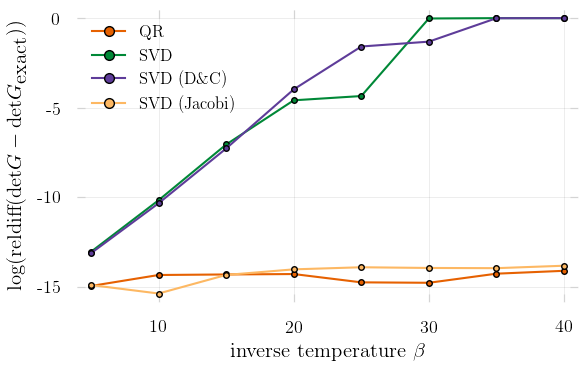

In [56]:
betas = collect(keys(Δs_rel_qr))

p = plot(betas, log.(10, values(Δs_rel_qr)), color="#E66101", marker=true, label="QR")
plot!(betas, log.(10, values(Δs_rel_gesvd)), color="#008837", marker=true, label="SVD")
plot!(betas, log.(10, values(Δs_rel_gesdd)), color="#5E3C99", marker=true, label="SVD (D\\&C)")
plot!(betas, log.(10, values(Δs_rel_gesvj)), color="#FDB863", marker=true, label="SVD (Jacobi)")

xlabel!(L"inverse temperature $\beta$")
ylabel!(L"\log(\textrm{reldiff}(\textrm{det}G - \textrm{det}G_{\textrm{exact}}))")
savefig("../paper/figures/accuracy_det_svd_regularinv.pdf")

In [58]:
Δs_abs_qr, Δs_abs_gesvd, Δs_abs_gesdd, Δs_abs_gesvj,
Δs_rel_qr, Δs_rel_gesvd, Δs_rel_gesdd, Δs_rel_gesvj = accuracy_determinant(B, svdinversion = svd_inv_one_plus_loh)

(SortedDict(5=>2.27871e-27,10=>3.48077e-38,15=>1.25375e-49,20=>4.12989e-61,25=>4.19818e-73,30=>1.13429e-84,35=>1.02002e-95,40=>4.05973e-107), SortedDict(5=>7.09185e-25,10=>2.87967e-31,15=>2.38255e-38,20=>7.4656e-46,25=>1.08873e-51,30=>2.60306e-50,35=>2.2983e-51,40=>9.32745e-50), SortedDict(5=>1.7976e-24,10=>3.08706e-31,15=>1.23296e-38,20=>7.59819e-45,25=>8.34591e-52,30=>6.84727e-52,35=>1.12897e-54,40=>7.59607e-60), SortedDict(5=>2.77e-27,10=>6.15506e-39,15=>1.3121e-49,20=>7.9272e-61,25=>2.83457e-72,30=>6.98963e-84,35=>2.02658e-95,40=>6.57193e-107), SortedDict(5=>1.09819e-15,10=>4.50618e-15,15=>4.82752e-15,20=>5.09667e-15,25=>1.75072e-15,30=>1.65611e-15,35=>5.33514e-15,40=>7.71777e-15), SortedDict(5=>3.41781e-13,10=>3.728e-8,15=>0.000916551,20=>0.902088,25=>1.0,30=>1.0,35=>1.0,40=>1.0), SortedDict(5=>8.66325e-13,10=>3.99648e-8,15=>0.000474523,20=>0.989448,25=>1.0,30=>1.0,35=>1.0,40=>1.0), SortedDict(5=>1.33496e-15,10=>7.96828e-16,15=>5.0522e-15,20=>9.78292e-15,25=>1.18207e-14,30=>1.0205

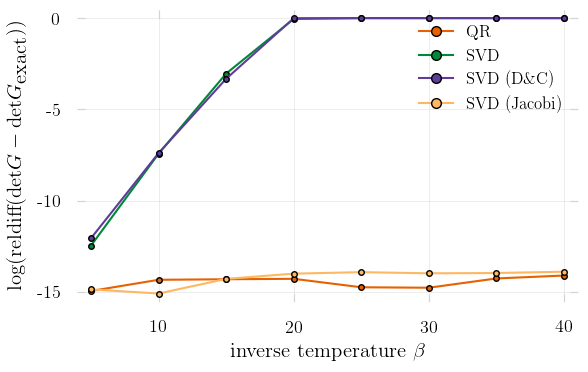

In [59]:
betas = collect(keys(Δs_rel_qr))
p = plot(betas, log.(10, values(Δs_rel_qr)), color="#E66101", marker=true, label="QR")
plot!(betas, log.(10, values(Δs_rel_gesvd)), color="#008837", marker=true, label="SVD")
plot!(betas, log.(10, values(Δs_rel_gesdd)), color="#5E3C99", marker=true, label="SVD (D\\&C)")
plot!(betas, log.(10, values(Δs_rel_gesvj)), color="#FDB863", marker=true, label="SVD (Jacobi)")

xlabel!(L"inverse temperature $\beta$")
ylabel!(L"\log(\textrm{reldiff}(\textrm{det}G - \textrm{det}G_{\textrm{exact}}))")
savefig("../paper/figures/accuracy_det_svd_loh.pdf")

# Performance: Decompositions

In [15]:
function benchmark_decomps(; evals=3)
    Ns = Int.(range(100, 500, step=100))
    df = DataFrame(N=Int[], qr=Float64[], gesdd=Float64[], gesvd=Float64[], gesvj=Float64[])

    for N in Ns
        x = rand(ComplexF64, N,N)
        t_qr = @belapsed udt($x) evals=evals
        t_gesdd = @belapsed gesdd($x) evals=evals
        t_gesvd = @belapsed gesvd($x) evals=evals
        t_gesvj = @belapsed gesvj($x) evals=1
        push!(df, [N, t_qr, t_gesdd, t_gesvd, t_gesvj])
    end
    
    return df
end

benchmark_decomps (generic function with 1 method)

In [16]:
df_decomps = benchmark_decomps()

,N,qr,gesdd,gesvd,gesvj
,Int64,Float64,Float64,Float64,Float64
1,100,0.00302207,0.00487103,0.0135197,0.0378208
2,200,0.0120884,0.0197974,0.0791047,0.265104
3,300,0.0275198,0.050847,0.261592,0.859603
4,400,0.0482108,0.0936244,0.64885,1.96787
5,500,0.0741627,0.149798,1.35569,3.68323


In [152]:
@df df_decomps plot(:N, [:gesvd ./ :qr, :gesdd ./ :qr, :gesvj ./ :qr],
            marker=true,
            color=permutedims(["#008837", "#5E3C99", "#FDB863"]),
            label=permutedims(["SVD", "SVD (D\\&C)", "SVD (Jacobi)"]),
#             yscale=:log10
            ylims=(0,29)
           )
@df df_decomps plot!(:N, fill(1, length(:N)), color=:grey, linestyle=:dash, label="QR")
xlabel!(L"N of $N\times N$ square matrix")
ylabel!("slowdown factor rel. to QR")
savefig("../paper/figures/benchmark_decomps.pdf")

UndefVarError: UndefVarError: df_decomps not defined

# Performance: Calculate Greens (regular inversion scheme)

In [18]:
function benchmark_inv_one_plus(; evals=3)
    Ns = Int.(range(100, 500, step=100))
    df = DataFrame(N=Int[], qr=Float64[], gesdd=Float64[], gesvd=Float64[], gesvj=Float64[])

    for N in Ns
        x = rand(ComplexF64, N,N)
        u = udt(x)
        s = svd(x)
        
        t_qr = @belapsed udt_inv_one_plus($u) evals=evals
        t_gesdd = @belapsed svd_inv_one_plus($s, svdalg = $gesdd!) evals=evals
        t_gesvd = @belapsed svd_inv_one_plus($s, svdalg = $gesvd!) evals=evals
        t_gesvj = @belapsed svd_inv_one_plus($s, svdalg = $StableDQMC.gesvj!) evals=evals
        push!(df, [N, t_qr, t_gesdd, t_gesvd, t_gesvj])
    end
    
    return df
end

benchmark_inv_one_plus (generic function with 1 method)

In [19]:
df_greens = benchmark_inv_one_plus(evals=1)

,N,qr,gesdd,gesvd,gesvj
,Int64,Float64,Float64,Float64,Float64
1,100,0.0065191,0.0047234,0.0136882,0.0169193
2,200,0.0214869,0.0202294,0.0817884,0.10562
3,300,0.0455522,0.0534273,0.266818,0.329224
4,400,0.0825547,0.103141,0.660864,0.730378
5,500,0.128501,0.173355,1.38737,1.44857


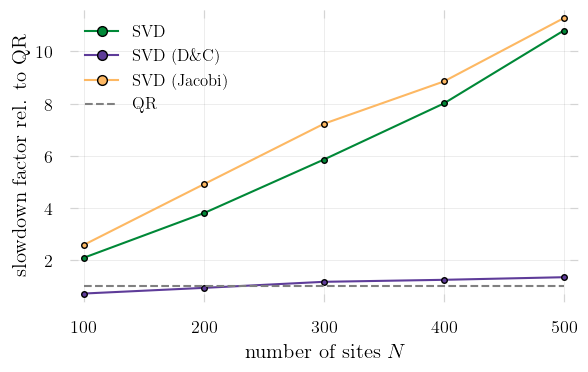

In [22]:
@df df_greens plot(:N, [:gesvd ./ :qr, :gesdd ./ :qr, :gesvj ./ :qr],
            marker=true,
            color=permutedims(["#008837", "#5E3C99", "#FDB863"]), # #E66101 for QR
            label=permutedims(["SVD", "SVD (D\\&C)", "SVD (Jacobi)"]),
#             yscale=:log10
#             ylims=(0,50)
           )
@df df_greens plot!(:N, fill(1, length(:N)), color=:grey, linestyle=:dash, label="QR")
xlabel!(L"number of sites $N$")
ylabel!("slowdown factor rel. to QR")
savefig("../paper/figures/benchmark_fact_inv_one_plus.pdf")

In [23]:
function benchmark_inv_one_plus_loh(; evals=3)
    Ns = Int.(range(100, 500, step=100))
    df = DataFrame(N=Int[], qr=Float64[], gesdd=Float64[], gesvd=Float64[], gesvj=Float64[])

    for N in Ns
        x = rand(ComplexF64, N,N)
        u = udt(x)
        s = svd(x)
        
        t_qr = @belapsed udt_inv_one_plus_loh($u) evals=evals
        t_gesdd = @belapsed svd_inv_one_plus_loh($s, svdalg = $gesdd!) evals=evals
        t_gesvd = @belapsed svd_inv_one_plus_loh($s, svdalg = $gesvd!) evals=evals
        t_gesvj = @belapsed svd_inv_one_plus_loh($s, svdalg = $StableDQMC.gesvj!) evals=evals
        push!(df, [N, t_qr, t_gesdd, t_gesvd, t_gesvj])
    end
    
    return df
end

benchmark_inv_one_plus_loh (generic function with 1 method)

In [24]:
df_loh = benchmark_inv_one_plus_loh()

,N,qr,gesdd,gesvd,gesvj
,Int64,Float64,Float64,Float64,Float64
1,100,0.0109235,0.0100744,0.0360362,0.0872705
2,200,0.0416139,0.0434961,0.210825,0.570747
3,300,0.0996223,0.110442,0.654335,1.82193
4,400,0.192457,0.209017,1.7182,4.19433
5,500,0.323953,0.33808,3.62439,8.17857


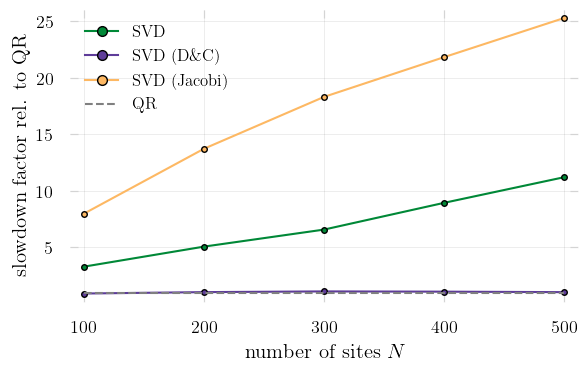

In [25]:
@df df_loh plot(:N, [:gesvd ./ :qr, :gesdd ./ :qr, :gesvj ./ :qr],
            marker=true,
            color=permutedims(["#008837", "#5E3C99", "#FDB863"]), # #E66101 for QR
            label=permutedims(["SVD", "SVD (D\\&C)", "SVD (Jacobi)"]),
#             yscale=:log10
#             ylims=(0,50)
           )
@df df_loh plot!(:N, fill(1, length(:N)), color=:grey, linestyle=:dash, label="QR")
xlabel!(L"number of sites $N$")
ylabel!("slowdown factor rel. to QR")
savefig("../paper/figures/benchmark_fact_inv_one_plus_loh.pdf")

# Accuracy: TDGF

In [142]:
# G(slice, 1) = [B(slice, 1)^-1 + B(beta, slice)]^-1
function accuracy_tdgf(B; loh = false) 
    Bbig = BigFloat.(B)
    
#     betas = range(5, 40, step=5)
    beta = 20
    M = Int(beta * 10)
    slices = 1:10:M

    df = DataFrame(slice=Int[], qr=Float64[], gesdd=Float64[], gesvd=Float64[], gesvj=Float64[])
    
    inv_sum_method = loh ? inv_sum_loh : inv_sum
    
    for s in slices
        local TDGF_genericsvd
        setprecision(1000) do
            TDGF_genericsvd = calc_tdgf_svd(Bbig, s, M-s, inv_sum_method = inv_sum_method, svdalg = genericsvd!)
        end
        
        TDGF_qr = calc_tdgf_qr(B, s, M-s, inv_sum_method = inv_sum_method)
        TDGF_gesdd = calc_tdgf_svd(B, s, M-s, inv_sum_method = inv_sum_method, svdalg = gesdd!)
        TDGF_gesvd = calc_tdgf_svd(B, s, M-s, inv_sum_method = inv_sum_method, svdalg = gesvd!)
        TDGF_gesvj = calc_tdgf_svd(B, s, M-s, inv_sum_method = inv_sum_method, svdalg = StableDQMC.gesvj!)
        
        Δ_qr    = mean(abs, TDGF_qr - TDGF_genericsvd)
        Δ_gesdd = mean(abs, TDGF_gesdd - TDGF_genericsvd)
        Δ_gesvd = mean(abs, TDGF_gesvd - TDGF_genericsvd)
        Δ_gesvj = mean(abs, TDGF_gesvj - TDGF_genericsvd)
        
        push!(df, [s, Δ_qr, Δ_gesdd, Δ_gesvd, Δ_gesvj])
    end

    return df
end

accuracy_tdgf (generic function with 1 method)

In [143]:
df_tdgf = accuracy_tdgf(B; loh = false)

,slice,qr,gesdd,gesvd,gesvj
,Int64,Float64,Float64,Float64,Float64
1,1,2.29725e-16,5.25049e-5,5.25049e-5,1.10104e-5
2,11,1.18337e-16,1.74961e-6,1.74961e-6,1.08784e-6
3,21,1.11212e-16,1.8995e-7,1.8995e-7,1.8995e-7
4,31,4.66896e-16,2.45378e-8,2.45378e-8,2.45378e-8
5,41,1.60815e-15,5.1155e-9,5.1155e-9,5.1155e-9
6,51,1.2601e-15,2.00715e-9,2.00715e-9,2.00431e-9
7,61,5.30044e-14,5.19831e-10,5.19831e-10,5.00722e-10
8,71,1.02379e-12,1.45396e-10,1.45396e-10,1.47018e-10
9,81,8.55758e-12,4.32199e-11,4.32199e-11,4.33184e-11


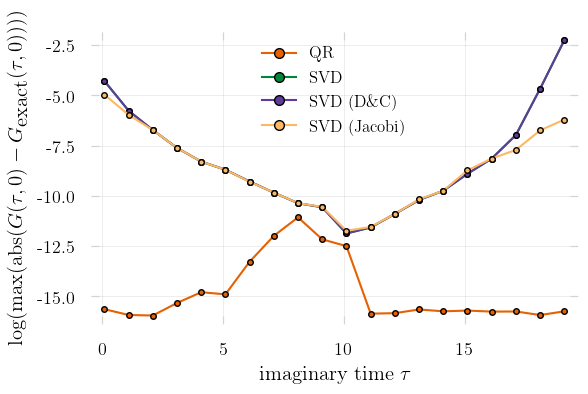

In [147]:
@df df_tdgf plot(:slice .* 0.1, (x -> log.(10, x)).([:qr, :gesvd, :gesdd, :gesvj]),
            marker=true,
            color=permutedims(["#E66101", "#008837", "#5E3C99", "#FDB863"]), # #E66101 for QR
            label=permutedims(["QR", "SVD", "SVD (D\\&C)", "SVD (Jacobi)"]),
#             xlims=(0,10)
           )
xlabel!(L"imaginary time $\tau$")
ylabel!(L"\log(\textrm{max}(\textrm{abs}(G(\tau, 0) - G_{\textrm{exact}}(\tau, 0))))")
savefig("../paper/figures/accuracy_tdgf.pdf")

In [145]:
df_tdgf_loh = accuracy_tdgf(B; loh = true)

,slice,qr,gesdd,gesvd,gesvj
,Int64,Float64,Float64,Float64,Float64
1,1,2.25466e-16,1.10104e-5,1.10104e-5,1.10104e-5
2,11,1.04854e-16,1.08784e-6,1.08784e-6,1.08784e-6
3,21,1.11567e-16,1.8995e-7,1.8995e-7,1.8995e-7
4,31,1.13866e-16,2.45378e-8,2.45378e-8,2.45378e-8
5,41,1.23081e-16,5.1155e-9,5.1155e-9,5.1155e-9
6,51,1.18294e-16,2.00431e-9,2.00431e-9,2.00431e-9
7,61,1.63841e-16,5.00722e-10,5.00722e-10,5.00722e-10
8,71,1.45813e-16,1.47018e-10,1.47018e-10,1.47018e-10
9,81,1.29529e-16,4.33184e-11,4.33184e-11,4.33184e-11


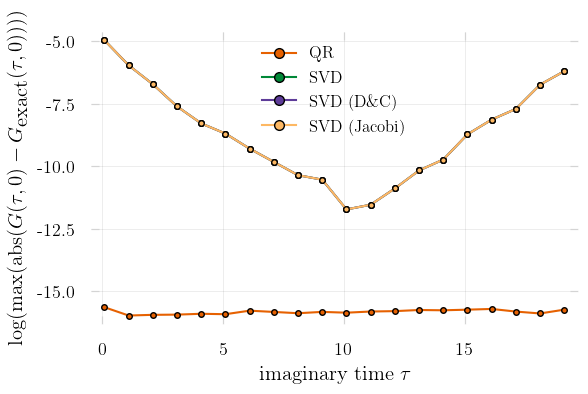

kpsewhich: warning: running with administrator privileges
kpsewhich: warning: running with administrator privileges
kpsewhich: warning: running with administrator privileges
kpsewhich: warning: running with administrator privileges


In [146]:
@df df_tdgf_loh plot(:slice .* 0.1, (x -> log.(10, x)).([:qr, :gesvd, :gesdd, :gesvj]),
            marker=true,
            color=permutedims(["#E66101", "#008837", "#5E3C99", "#FDB863"]), # #E66101 for QR
            label=permutedims(["QR", "SVD", "SVD (D\\&C)", "SVD (Jacobi)"]),
#             xlims=(0,10)
           )
xlabel!(L"imaginary time $\tau$")
ylabel!(L"\log(\textrm{max}(\textrm{abs}(G(\tau, 0) - G_{\textrm{exact}}(\tau, 0))))")
savefig("../paper/figures/accuracy_tdgf_loh.pdf")